In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

In [84]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
        
    Output:
    ------
        close_value
    '''
    
    value = np.asarray(value)
    data = np.asarray(data)
    
    close_value = data[(np.abs(np.subtract(data,value))).argmin()]
    return close_value

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones
    '''
    def __init__(self,band,distance,isochrones):
        
        '''
        distance: [float] distance to star in pc
        band: [str] photometric band of interest
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.dist = distance
        
        # PARSEC isochrones
        self.band = band
        self.iso = isochrones
        
    def Teff2AppMag(self,teff_feh,age,al):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff_feh: (teff,feh) temperature and metallicity of star
            age: age of star
            al: extinction in the same band used to initialize the class
            
            # parameters defined in __init__
            self.iso: set of PARSEC isochrones 
            self.dist: distance to star
            self.band: band of interest
            
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
    
        # 
        teff = teff_feh[0]
        feh = teff_feh[1]
        
        # Select a single isochrone to calculate the magnitude
        single = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age*10**9)))&
                                   (self.iso['MH']==closest(self.iso['MH'],np.mean(feh))))]
    
        # Sort temperature and magnitudes so that x (teff) is increasing for a spline
        sidx = np.argsort(single['logTe'])
        slogTe = single['logTe'][sidx]
        smag = single[self.band][sidx]

        _, uidx = np.unique(slogTe,return_index=True)
    
        # Use a spline to determine the absolute magnitude of a star as a function of temperature
        spl = InterpolatedUnivariateSpline(slogTe[uidx],smag[uidx])
    
        # Calculate the apparent magnitude of the star
        calc_mag = spl(np.log10(teff))+5.0*np.log10(self.dist)-5.0+al
        
        # print is here to see what values curve_fit is spitting out at each iteration
        print(calc_mag)
        
        return calc_mag
        
#     def MCDistribution(self,teff,teff_err,feh,feh_err,am,am_err,mag,mag_err,number):
#         '''
#         Generate a distribution to do a Monte Simulation to calculate age and extinction
            
#         Inputs:
#         ------
            
#             teff: temperature of star
#             teff_err: error in temperature of star
#             feh: metallicity of star
#             feh_err: error in metallicity of star
#             am: alpha abundance of star
#             am_err: error in alpha abundance of star
#             mag: magnitude of star corresponding to self.band 
#             mag_err: error in magnitude of star corresponding to self.band
#             number: number of points to sample
              
#         Outputs:
#         -------
#             noisy_feh
#             noisy_teff
#             noisy_mag
#         '''
            
#         noisy_teff = np.random.normal(teff,teff_err,number)
#         noisy_feh = np.random.normal(feh,feh_err,number)
#         noisy_am = np.random.normal(am,am_err,number)
#         noisy_mag = np.random.normal(mag,mag_err,number)
            
#         return noisy_teff, noisy_feh, noisy_am, noisy_mag
    
    def Salaris(self,feh,am):
        '''
        Calculate the Salaris et al. 1993 corrected [Fe/H]
        
        Inputs:
        ------
            feh: uncorrected metallicity of star
            am: alpha abundance of star
        
        Output:
        ------
            sal_feh: corrected metallicity
        '''
        
        sal_feh = feh + np.log10(0.638*(10**am)+0.362)
        return sal_feh

# Parsec

In [3]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [43]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


# Test Code

In [5]:
from scipy.optimize import curve_fit

In [90]:
# pick star
g_idx = 1000

# initialize class
CalcAgek = WhatsMyAgeAgain('Ksmag',10400,massive)

# do Salaris Correction
feh = CalcAgek.Salaris(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx])

# print measured apparent K
print('Measured K:',gcs['K'][g_idx])

# curve_fit does its thing
poptk, pcovk = curve_fit(CalcAgek.Teff2AppMag,np.array([gcs['TEFF'][g_idx],feh]).T,gcs['K'][g_idx],
                           method='dogbox')

# print parameters and cov matrix
print('(age, extinction): ',poptk)
print('cov matrix: ',pcovk)

Measured K: 10.787
22.776525169525772
22.776525169525772
22.776525184426934
21.776525169525772
21.776525169525772
21.776525184426934
19.776525169525772
19.776525169525772
19.77652513972345
15.776525169525772
15.776525169525772
15.776525080118805
10.786999702453613
10.786999702453613
10.786999538696923
(age, extinction):  [  1.         -10.98952547]
cov matrix:  [[inf inf]
 [inf inf]]


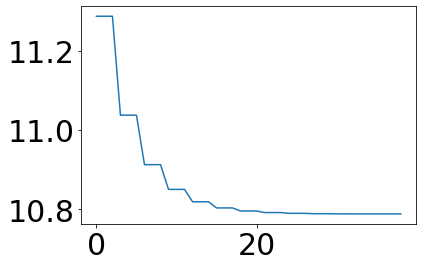

In [76]:
points = [11.28803568734628,11.28803568734628,11.288035702247441,11.037776959161604,11.037776959161604,
          11.037776974062766,10.912647863107182,10.912647863107182,10.912647878008343,10.850083851151785,
          10.850083851151785,10.850083866052946,10.818802917285563,10.818802917285563,10.818802932186724,
          10.803164594318217,10.803164594318217,10.803164609219378,10.795349718709526,10.795349718709526,
          10.795349733610687,10.791450836232645,10.791450836232645,10.791450851133806,10.789518375219593,
          10.789518375219593,10.789518390120755,10.788585091293548,10.788585091293548,10.78858510619471,
          10.788177080318508,10.788177080318508,10.78817709521967,10.788050846896395,10.788050846896395,
          10.788050861797556,10.788035902868272,10.788035902868272,10.788035917769433]

plt.plot(points)

In [74]:
len(np.unique(massive['logAge']))

560

In [67]:
# params = []
# for i in tqdm_notebook(range(len(np.unique(massive['logAge'])))):
#     g_idx = 1000
#     CalcAgek = WhatsMyAgeAgain('Ksmag',10400,massive)

#     feh = CalcAgek.Salaris(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx])

#     poptk,_ = curve_fit(CalcAgek.Teff2AppMag,np.array([gcs['TEFF'][g_idx],feh]).T,gcs['K'][g_idx],
#                          p0=[10**np.unique(massive['logAge'])[i]/10**9,gcs['AK_TARG'][g_idx]],method='trf',
#                          bounds=((0.,0.),(14.,1.0)))
    
#     params.append(poptk)

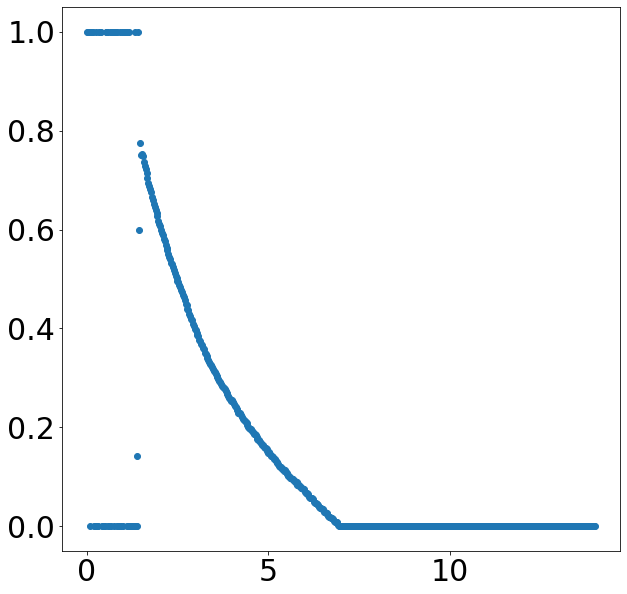

In [60]:
plt.figure(figsize=[10,10])
plt.scatter(np.asarray(params)[:,0],np.asarray(params)[:,1])

In [62]:
gcs['AK_TARG'][g_idx]

0.0038830237

In [61]:
params

[array([0.025, 1.   ]),
 array([0.05, 1.  ]),
 array([0.07499978, 1.        ]),
 array([1.00000000e-01, 1.49556053e-14]),
 array([0.125, 1.   ]),
 array([0.14999957, 1.        ]),
 array([0.17500079, 1.        ]),
 array([2.00000002e-01, 2.54914293e-17]),
 array([2.24998695e-01, 7.53605794e-08]),
 array([0.25      , 0.99999998]),
 array([2.74998294e-01, 2.49971539e-12]),
 array([2.99999133e-01, 1.41165663e-09]),
 array([3.24997485e-01, 2.68876613e-12]),
 array([0.35000158, 1.        ]),
 array([0.37499891, 1.        ]),
 array([0.40000001, 1.        ]),
 array([4.25001047e-01, 4.24506728e-12]),
 array([4.49997395e-01, 6.34368490e-13]),
 array([4.74996052e-01, 7.66108162e-12]),
 array([4.99999995e-01, 1.05787794e-12]),
 array([0.52500084, 1.        ]),
 array([0.54999659, 1.        ]),
 array([0.57500285, 1.        ]),
 array([5.99998273e-01, 7.58346324e-10]),
 array([6.24999975e-01, 1.09119321e-14]),
 array([0.64999498, 1.        ]),
 array([6.74994136e-01, 2.64835653e-14]),
 array([0.

In [63]:
gcs['K'][g_idx]

10.787

Text(0, 0.5, 'Ksmag')

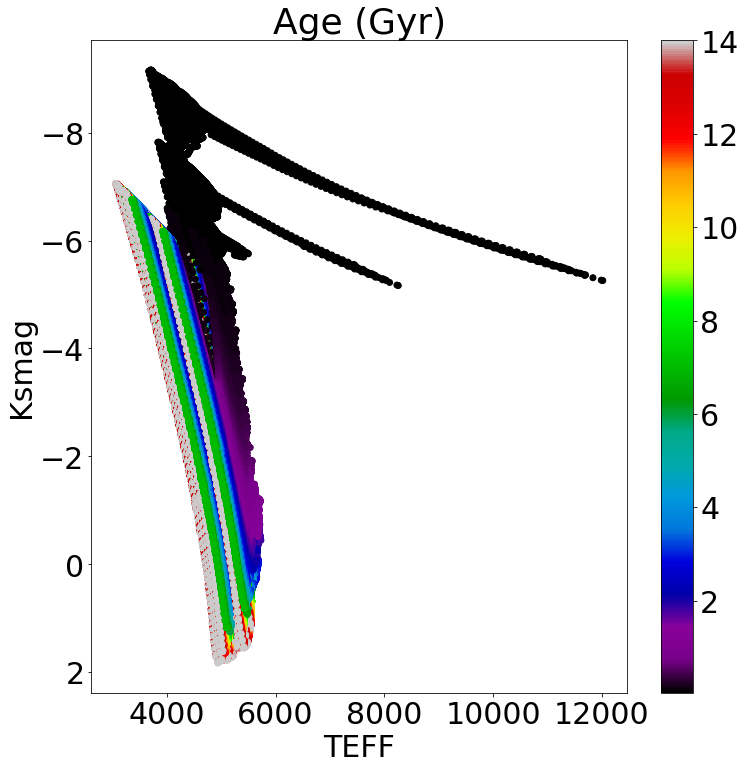

In [31]:
plt.figure(figsize=[12,12])
plt.scatter(10**massive['logTe'],massive['Ksmag'],c=10**massive['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Age (Gyr)')
plt.xlabel(r'TEFF')
plt.ylabel(r'Ksmag')

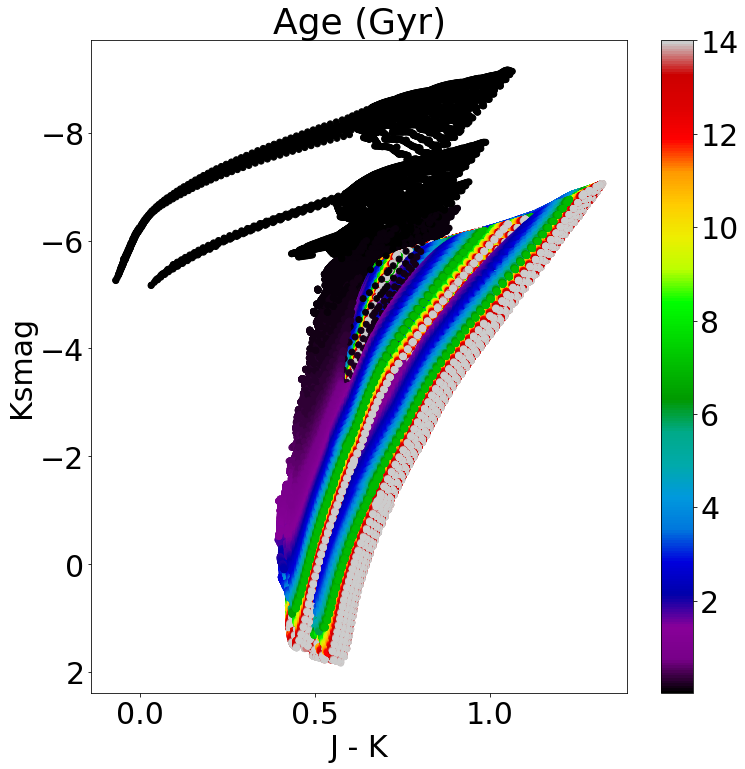

In [33]:
plt.figure(figsize=[12,12])
plt.scatter(massive['Jmag']-massive['Ksmag'],massive['Ksmag'],c=10**massive['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Age (Gyr)')
plt.xlabel(r'J - K')
plt.ylabel(r'Ksmag')
plt.show()

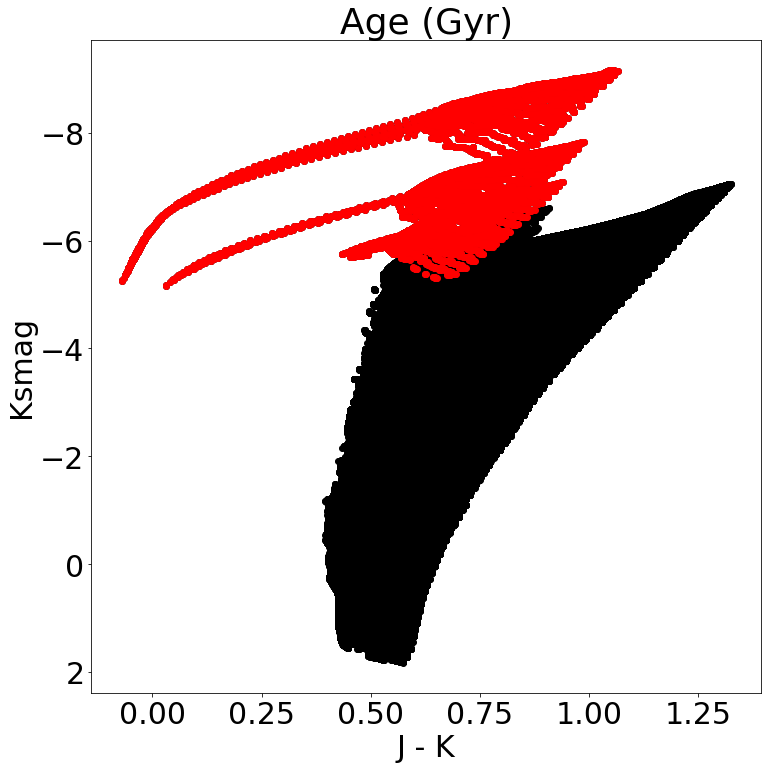

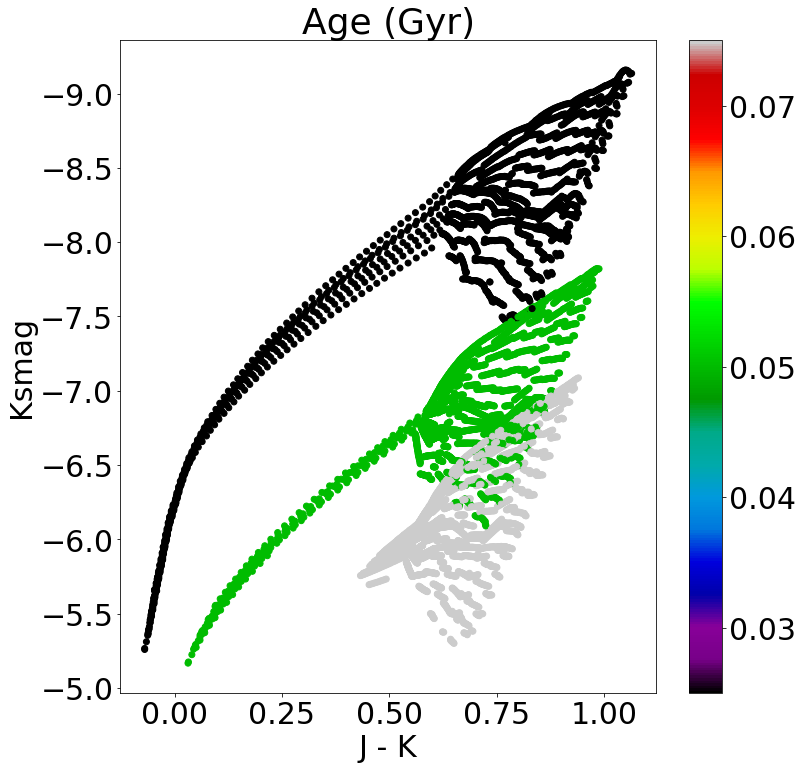

In [42]:
cut = np.where(massive['logAge']<np.log10(0.095*10**9))
plt.figure(figsize=[12,12])
plt.scatter(massive['Jmag']-massive['Ksmag'],massive['Ksmag'],c='k')
plt.scatter((massive['Jmag']-massive['Ksmag'])[cut],massive['Ksmag'][cut],c='r')
plt.gca().invert_yaxis()
plt.title(r'Age (Gyr)')
plt.xlabel(r'J - K')
plt.ylabel(r'Ksmag')
plt.show()

plt.figure(figsize=[12,12])
plt.scatter((massive['Jmag']-massive['Ksmag'])[cut],massive['Ksmag'][cut],c=10**massive['logAge'][cut]/10**9,
            cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Age (Gyr)')
plt.xlabel(r'J - K')
plt.ylabel(r'Ksmag')
plt.show()

In [86]:


# nteffk, nmhk, namk, nmagk = CalcAgek.MCDistribution(gcs['TEFF'][g_idx],gcs['TEFF_ERR'][g_idx],gcs['M_H'][g_idx],
#                                                gcs['M_H_ERR'][g_idx],gcs['ALPHA_M'][g_idx],
#                                                gcs['ALPHA_M_ERR'][g_idx],gcs['K'][g_idx],gcs['K_ERR'][g_idx],
#                                                1000)
# nfehk = CalcAgek.Salaris(nmhk,namk)

# poptk1, pcovk1 = curve_fit(CalcAgek.Teff2AppMag,np.array([nteffk,nfehk]).T,nmagk,method='dogbox')
# print('None')
# print(poptk1)
# print(pcovk1)

# poptk2, pcovk2 = curve_fit(CalcAgek.Teff2AppMag,np.array([nteffk,nfehk]).T,nmagk,bounds=((0.0,0.0),(14.0,1.0)),
#                            method='dogbox')
# print('0-14, 0-1')
# print(poptk2)
# print(pcovk2)

# poptk3, pcovk3 = curve_fit(CalcAgek.Teff2AppMag,np.array([nteffk,nfehk]).T,nmagk,
#                            bounds=((0.0,0.0),(np.inf,np.inf)),method='dogbox')
# print('0-inf, 0-inf')
# print(poptk3)
# print(pcovk3)

# poptk4, pcovk4 = curve_fit(CalcAgek.Teff2AppMag,np.array([nteffk,nfehk]).T,nmagk,
#                            bounds=((10.0,0.0),(np.inf,1.0)),method='dogbox')
# print('10-inf, 0-inf')
# print(poptk4)
# print(pcovk4)

# poptk5, pcovk5 = curve_fit(CalcAgek.Teff2AppMag,np.array([nteffk,nfehk]).T,nmagk,
#                            bounds=((10.0,0.0),(14.0,1.0)),method='dogbox')
# print('10-inf, 14-inf')
# print(poptk5)
# print(pcovk5)

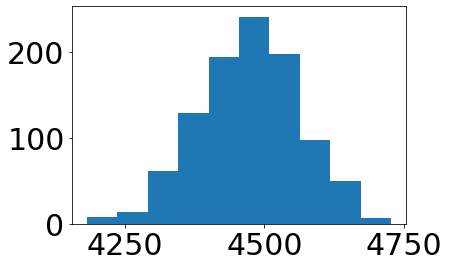

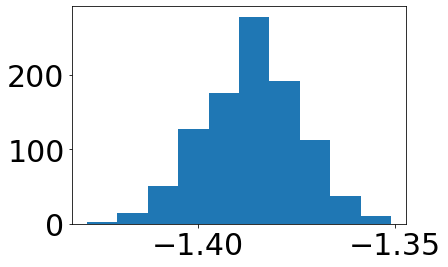

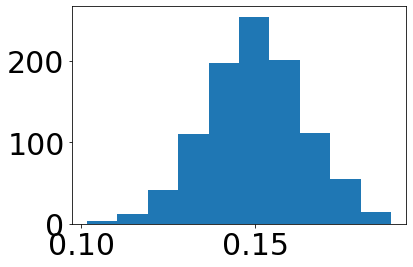

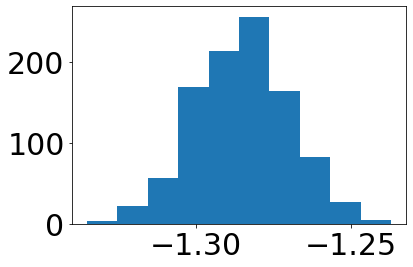

In [88]:
plt.hist(nteffk)
plt.show()

plt.hist(nmhk)
plt.show()

plt.hist(namk)
plt.show()

plt.hist(nfehk)
plt.show()

In [10]:
np.where(gcs['CLUSTER']=='M3')

(array([ 970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,
         981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
         992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002,
        1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
        1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
        1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
        1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046,
        1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057,
        1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
        1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
        1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090,
        1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101,
        1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112,
        1113, 1114, 1115, 1116, 1117, 

In [11]:
g_idx2 = 1168
CalcAgek = WhatsMyAgeAgain('Jmag',10400,massive)
poptk, pcovk = curve_fit(CalcAgek.Teff2AppMag,np.array([gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2]]).T,
                         gcs['J'][g_idx2],method='dogbox')
#,bounds=((0.0,0.0),(14,0.6)),

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
g_idx = 1000
CalcAgej = WhatsMyAgeAgain('Jmag',10400,massive)

nteffj, nmhj, namj, nmagj = CalcAgej.MCDistribution(gcs['TEFF'][g_idx],gcs['TEFF_ERR'][g_idx],gcs['M_H'][g_idx],
                                               gcs['M_H_ERR'][g_idx],gcs['ALPHA_M'][g_idx],
                                               gcs['ALPHA_M_ERR'][g_idx],gcs['J'][g_idx],gcs['J_ERR'][g_idx],
                                               1000)
nfehj = CalcAgej.Salaris(nmhj,namj)

poptj, pcovj = curve_fit(CalcAgej.Teff2AppMag,np.array([nteffj,nfehj]).T,nmagj,
                         bounds=((0.0,0.0),(14.0,1.0)),method='trf')
print(poptj)
print(pcovj)

In [ ]:
g_idx = 1000
CalcAgeh = WhatsMyAgeAgain('Hmag',10400,massive)

nteffh, nmhh, namh, nmagh = CalcAgeh.MCDistribution(gcs['TEFF'][g_idx],gcs['TEFF_ERR'][g_idx],gcs['M_H'][g_idx],
                                               gcs['M_H_ERR'][g_idx],gcs['ALPHA_M'][g_idx],
                                               gcs['ALPHA_M_ERR'][g_idx],gcs['H'][g_idx],gcs['H_ERR'][g_idx],
                                               1000)
nfehh = CalcAgeh.Salaris(nmhh,namh)

popth, pcovh = curve_fit(CalcAgeh.Teff2AppMag,np.array([nteffh,nfehh]).T,nmagh,
                         bounds=((0.0,0.0),(14.0,1.0)),method='trf')
print(popth)
print(pcovh)

### Whole Clusters

In [13]:
np.squeeze(np.where(gcs['CLUSTER']=='M3'))

array([ 970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,
        981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
        992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002,
       1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
       1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
       1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046,
       1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057,
       1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
       1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
       1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090,
       1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101,
       1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112,
       1113, 1114, 1115, 1116, 1117, 1118, 1119, 11

In [14]:
from tqdm import tqdm_notebook

m3_ages = []
m3_ak = []
CalcAgeM3 = WhatsMyAgeAgain('Ksmag',10400,massive)
for i in tqdm_notebook(np.squeeze(np.where(gcs['CLUSTER']=='M3'))):
    nteff,nmh,nam,nmag = CalcAgeM3.MCDistribution(gcs['TEFF'][i],gcs['TEFF_ERR'][i],gcs['M_H'][i],
                                                  gcs['M_H_ERR'][i],gcs['ALPHA_M'][i],gcs['ALPHA_M_ERR'][i],
                                                  gcs['K'][i],gcs['K_ERR'][i],1000)
    nfeh = CalcAgeM3.Salaris(nmh,nam)
    popt, _ = curve_fit(CalcAgeM3.Teff2AppMag,np.array([nteff,nfeh]).T,nmag,bounds=((0.0,0.0),(14.0,1.0)),
                        method='trf')
    m3_ages.append(popt[0])
    m3_ak.append(popt[1])

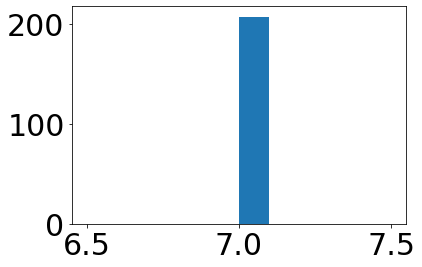

7.0


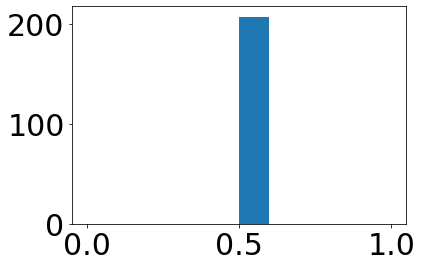

0.5


In [15]:
plt.hist(m3_ages)
plt.show()
print(np.median(m3_ages))

plt.hist(m3_ak)
plt.show()
print(np.median(m3_ak))

In [16]:
print(gcs['FE_H'][1000]+np.log10(0.638*(10**(gcs['ALPHA_M'][1000]+gcs['M_H'][1000]-gcs['FE_H'][1000]))+0.362))
print(gcs['M_H'][1000]+np.log10(0.638*(10**gcs['ALPHA_M'][1000])+0.362))
CalcAgek.Salaris(gcs['M_H'][1000],gcs['ALPHA_M'][1000])

-1.2879385521104427
-1.2854902431485307


-1.2854902431485307

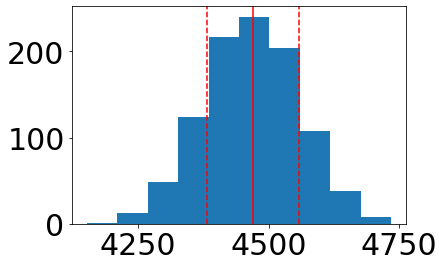

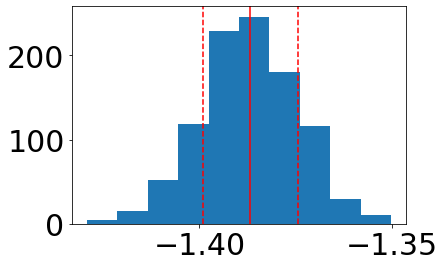

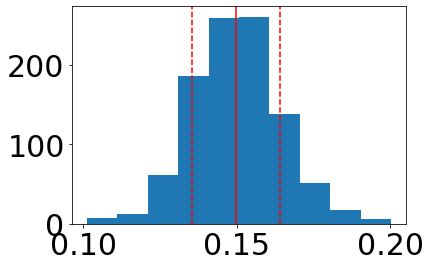

In [17]:
# teff
plt.hist(nteffk)
plt.axvline(gcs['TEFF'][1000],c='r')
plt.axvline(gcs['TEFF'][1000]+gcs['TEFF_ERR'][1000],c='r',ls='--')
plt.axvline(gcs['TEFF'][1000]-gcs['TEFF_ERR'][1000],c='r',ls='--')
plt.show()

# Metallicity
plt.hist(nmhk)
plt.axvline(gcs['M_H'][1000],c='r')
plt.axvline(gcs['M_H'][1000]+gcs['M_H_ERR'][1000],c='r',ls='--')
plt.axvline(gcs['M_H'][1000]-gcs['M_H_ERR'][1000],c='r',ls='--')
plt.show()

# ALPHA_M
plt.hist(namk)
plt.axvline(gcs['ALPHA_M'][1000],c='r')
plt.axvline(gcs['ALPHA_M'][1000]+gcs['ALPHA_M_ERR'][1000],c='r',ls='--')
plt.axvline(gcs['ALPHA_M'][1000]-gcs['ALPHA_M_ERR'][1000],c='r',ls='--')
plt.show()